# Importação das bibliotecas

In [1]:
# Instala e importa todas as bibliotecas e módulos necessários.
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
import seaborn as sns
import matplotlib.pyplot as plt
!pip install bert-for-tf2
!pip install sentencepiece
!pip install tensorflow
!pip install --upgrade tensorflow_hub
!pip3 install h5py
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert

# Carregamento da base de dados

In [2]:
# Escolha do estilo musical para o qual se deseja treinar o programa.
#estilos_disponíveis = 
#print('Estilos disponíveis: alterntai',)
#parametro = input('Para qual estilo musical deseja treinar? ')
parametro = 'Alternativo'

# Processador DOM para pegar as músicas do arquivo xml.
from xml.etree import ElementTree as ET
file = 'Lyrics.xml'
dom = ET.parse(file)
root = dom.getroot()
musicas = root.findall('MUSICA')

# Em uma lista são armazenadas as letras e na outra são armazenados os estilos.
letras_treinamento = []
letras_treinamento_estilo = []
for m in musicas:
    letras_treinamento_estilo.append(m.attrib['estilo'])
    lyric = ''
    estrofes = m.findall('ESTROFE')
    for e in estrofes:
        versos = e.findall('VERSO')
        for v in versos: 
            lyric += v.text + '\n'
        lyric += '\n'
    letras_treinamento.append(lyric)

Para qual estilo musical deseja treinar? Alternativo


In [3]:
letras_treinamento[0]

"It doesn't hurt me\nDo you want to feel how it feels?\nDo you want to know, know that it doesn't hurt me?\nDo you want to hear about the deal that I'm making?\n\nYou\nIt's you and me\n\nAnd if I only could\nI'd make a deal with God\nAnd I'd get him to swap our places\nBe running up that road\nBe running up that hill\nBe running up that building\nSee, if I only could, oh\n\nYou don't want to hurt me\nBut see how deep the bullet lies\nUnaware I'm tearing you asunder\nOh, there is thunder in our hearts\n\nIs there so much hate for the ones we love?\nTell me, we both matter, don't we?\n\nYou\nIt's you and me\nIt's you and me, won't be unhappy\n\nAnd if I only could\nI'd make a deal with God\nAnd I'd get him to swap our places\nBe running up that road\nBe running up that hill\nBe running up that building\nSee, if I only could, oh\n\nYou\nIt's you and me\nIt's you and me, won't be unhappy\n\nOh, come on, baby\nOh, come on, darling\nLet me steal this moment from you now\n\nOh, come on, angel

## Pré-procesamento

In [4]:
# Faz com que o estilo escolhido para treinar seja representado por 1.
# Os outros estilos serão representados por 0.
for l in range(len(letras_treinamento_estilo)):
    if letras_treinamento_estilo[l] == parametro: letras_treinamento_estilo[l] = 1
    else: letras_treinamento_estilo[l] = 0
letras_treinamento_estilo = np.array(letras_treinamento_estilo)

In [5]:
letras_treinamento_estilo[0]

1

In [6]:
letras_treinamento_estilo[201]

0

### Limpeza dos textos

In [ ]:
# Função que limpa o texto.
# Não foi necessário com as letras, pois os textos já vêm limpos de acordo com os critérios abaixo.
def clean(texto):
    texto = BeautifulSoup(texto, 'lxml').get_text()
    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.!?']", ' ', texto)
    texto = re.sub(r" +", ' ', texto)
    return texto

In [ ]:
# Executa a função de limpeza para cada texto.
data_clean = [clean(text) for text in letras_treinamento]

### Tokenização

In [7]:
#É obtido o módulo mobilebert_multi_cased_L-24_H-128_B-512_A-4_F-4_OPT/1 e feito o processamento dele.
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/'\
                            'mobilebert_multi_cased_L-24_H-128_B-512_A-4_F-4_OPT/1', trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case) 

In [8]:
'''Função que faz com que as palavras do texto de input sejam tokenizadas
de acordo com o BERT multi-lingual.'''
def encode_sentence(texto):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texto))

In [9]:
# Tokeniza todas as letras usandoa a função 'encode_sentence'.
letras_treinamento_tokenizadas = [encode_sentence(sentence) for sentence in letras_treinamento]

### Criação da base de dados

In [11]:
'''Cria a lista que possui a letra tokenizada, o estilo 0 ou 1 em cada elemento e o tamanho da 
lista de tokens.'''
letras_with_len = [[sent, letras_treinamento_estilo[i],len(sent)]
                 for i, sent in enumerate(letras_treinamento_tokenizadas)]

In [12]:
letras_with_len[0]

[[10377,
  47798,
  112,
  188,
  52824,
  10123,
  10911,
  11791,
  13028,
  21528,
  10114,
  38008,
  14796,
  10271,
  84992,
  136,
  11791,
  13028,
  21528,
  10114,
  21852,
  117,
  21852,
  10189,
  10271,
  47798,
  112,
  188,
  52824,
  10123,
  10911,
  136,
  11791,
  13028,
  21528,
  10114,
  62064,
  10978,
  10105,
  19918,
  10189,
  146,
  112,
  181,
  14293,
  136,
  11065,
  10377,
  112,
  187,
  13028,
  10111,
  10911,
  12689,
  12277,
  146,
  10893,
  12174,
  146,
  112,
  172,
  13086,
  169,
  19918,
  10169,
  14015,
  12689,
  146,
  112,
  172,
  15329,
  10957,
  10114,
  187,
  11037,
  10410,
  17446,
  19261,
  14321,
  18020,
  10741,
  10189,
  15485,
  14321,
  18020,
  10741,
  10189,
  41473,
  14321,
  18020,
  10741,
  10189,
  12585,
  13924,
  117,
  12277,
  146,
  10893,
  12174,
  117,
  183,
  10237,
  11065,
  16938,
  112,
  188,
  21528,
  10114,
  52824,
  10123,
  10911,
  16976,
  12888,
  14796,
  26591,
  10105,
  11499,
  4

In [14]:
# Mistura os dados, porque originalmente elas estão agrupadas por estilo musical.
random.shuffle(letras_with_len)
# Ordena os dados para poder separá-los em batches.
# Elimina as letras que possui tamanho menor ou igual a 10 palavras.
letras_with_len.sort(key=lambda x: x[2])
letras_sorted_all = [(sent_lab[0], sent_lab[1])
              for sent_lab in letras_with_len if sent_lab[2] > 10]

In [15]:
# Transforma a base de dados no formato do Tensor Flow.
all_letras = tf.data.Dataset.from_generator(lambda: letras_sorted_all,
                                             output_types = (tf.int32, tf.int32))

In [16]:
next(iter(all_letras))

(<tf.Tensor: shape=(49,), dtype=int32, numpy=
 array([41859, 20514, 14444, 20514, 14444, 20514, 41859, 20514, 10201,
        15983, 10333, 13015, 16218, 41859, 20514, 14444, 20514, 14444,
        20514, 41859, 20514, 10201, 15983, 10333, 13015, 16218, 12404,
        54261,   183, 11859, 11790, 10201, 15983, 10333, 12404, 54261,
          183, 11859, 11790, 10201, 15983, 10333, 41859, 20514, 10201,
        15983, 10333, 13015, 16218])>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>)

In [18]:
# Define o tamanho do Batch e separa a base de dados em batches.
BATCH_SIZE = 20
#all_batched_letras = all_letras.batch(BATCH_SIZE)
all_batched_letras = all_letras.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [19]:
# Define o númeoro de batches para treinamento.
NB_BATCHES = len(letras_sorted_all) // BATCH_SIZE
NB_BATCHES

60

In [20]:
# Define o número de batches para teste.
NB_BATCHES_TEST = NB_BATCHES // 10
NB_BATCHES_TEST

6

In [22]:
# Dá um shuffle na base de dados e obtém batches de treinamento e de teste.
all_batched_letras.shuffle(NB_BATCHES)
test_dataset = all_batched_letras.take(NB_BATCHES_TEST)
train_dataset = all_batched_letras.skip(NB_BATCHES_TEST)

In [23]:
train_dataset

<SkipDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
next(iter(test_dataset))

(<tf.Tensor: shape=(20, 79), dtype=int32, numpy=
 array([[41859, 20514, 14444, ...,     0,     0,     0],
        [38354, 43951, 10190, ...,     0,     0,     0],
        [  235,   118, 10266, ...,     0,     0,     0],
        ...,
        [25474, 19048, 59482, ..., 25474, 19048,     0],
        [18389,   117, 63142, ..., 23972,   119,     0],
        [12515, 10617, 30668, ..., 11560, 30668, 21948]])>,
 <tf.Tensor: shape=(20,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])>)

In [25]:
next(iter(train_dataset))

(<tf.Tensor: shape=(20, 128), dtype=int32, numpy=
 array([[37025,   117, 10833, ...,     0,     0,     0],
        [12114, 57996, 10427, ...,     0,     0,     0],
        [12944, 22179, 96149, ...,     0,     0,     0],
        ...,
        [11469, 13420, 20442, ..., 10472, 10911,   136],
        [40751, 98553, 11791, ..., 67099, 40539,   106],
        [98978, 29095, 11926, ..., 41390,   169, 69532]])>,
 <tf.Tensor: shape=(20,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])>)

# Modelo

In [26]:
class Lyrics_Preview(tf.keras.Model):

    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters = 50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="lyrics_preview"):
        super(Lyrics_Preview, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size, emb_dim)

        self.bigram = layers.Conv1D(filters = nb_filters,
                                kernel_size = 2,
                                padding='valid',
                                activation='relu')
        self.trigram = layers.Conv1D(filters = nb_filters,
                                kernel_size = 3,
                                padding='valid',
                                activation='relu')
        self.fourgram = layers.Conv1D(filters = nb_filters,
                                kernel_size = 4,
                                padding='valid',
                                activation='relu')
    
        self.pool = layers.GlobalMaxPool1D()

        self.dense_1 = layers.Dense(units = FFN_units, activation='relu')
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1, activation='sigmoid')
        else:
            self.last_dense = layers.Dense(units=nb_classes, activation='softmax')

    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis = -1)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)

        return output

# Treinamento

In [27]:
# Definição dos Hiperparâmetros
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2
DROPOUT_RATE = 0.2
NB_EPOCHS = 5

In [28]:
# Cria um objeto da classe Lyrics_Preview
Dcnn = Lyrics_Preview(vocab_size = VOCAB_SIZE,
            emb_dim = EMB_DIM,
            nb_filters = NB_FILTERS,
            FFN_units = FFN_UNITS,
            nb_classes = NB_CLASSES,
            dropout_rate = DROPOUT_RATE)

In [29]:
# Compilação do modelo
if NB_CLASSES == 2:
    Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
    Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', \
                 metrics=['sparse_categorical_accuracy'])

In [30]:
# Cria o checkpoint para o treinamento. Salva em uma pasta chamada 'Checkpoints'
checkpoint_path = '/Checkpoints/'

In [31]:
# Variável que recebe o checkpoint
ckpt = tf.train.Checkpoint(Dcnn = Dcnn)

In [32]:
# max_to_keep é o número de versões que salva.
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

In [33]:
# Restore o último checkpoint
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!')

Latest checkpoint restored!


In [34]:
# Ao final de cada epoch é salvo o checkpoint.
class MyCustomCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        ckpt_manager.save()
        print("Checkpoint saved at {}".format(checkpoint_path))

In [35]:
# Execução do treinamento.
history = Dcnn.fit(train_dataset,
                   epochs = NB_EPOCHS,
                   #steps_per_epoch = 100,
                   callbacks = [MyCustomCallBack()])

Epoch 1/5
     54/Unknown - 14s 216ms/step - loss: 0.3353 - accuracy: 0.8648Checkpoint saved at /Checkpoints/
54/54 [==============================] - 15s 242ms/step - loss: 0.3353 - accuracy: 0.8648
Epoch 2/5
54/54 [==============================] - 13s 238ms/step - loss: 0.1781 - accuracy: 0.9417
Epoch 3/5
54/54 [==============================] - 12s 228ms/step - loss: 0.0503 - accuracy: 0.9880
Epoch 4/5
54/54 [==============================] - 12s 228ms/step - loss: 0.0317 - accuracy: 0.9898
Epoch 5/5
54/54 [==============================] - 13s 240ms/step - loss: 0.0066 - accuracy: 0.9991


# Avaliação

In [36]:
# Mostrar os valores de loss e de acuracy.
history.history.keys()

dict_keys(['loss', 'accuracy'])

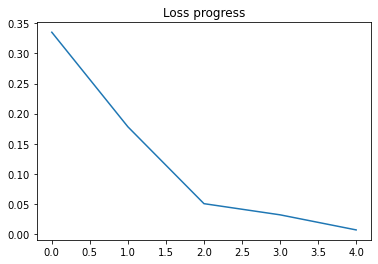

In [43]:
# Gráfico com o valor da 'loss'.
plt.plot(history.history['loss'])
plt.title('Loss progress')
plt.savefig('Loss.png')

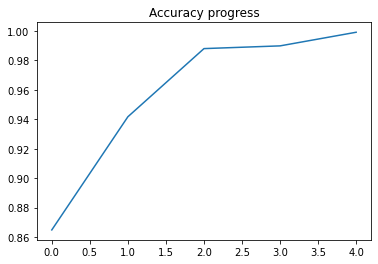

In [44]:
# Gráfico com o valor da 'accuracy'.
plt.plot(history.history['accuracy'])
plt.title('Accuracy progress')
plt.savefig('Accuracy.png')

In [39]:
# Testa o modelo com a base de dados de teste.
results = Dcnn.evaluate(test_dataset)
print(results)

6/6 [==============================] - 0s 8ms/step - loss: 0.2299 - accuracy: 0.9417
[0.2298603653907776, 0.9416666626930237]


In [40]:
# Função usada para prever o estilo musical de um texto genérico.
def get_prediction(sentence):
    tokens = encode_sentence(sentence)
    inputs = tf.expand_dims(tokens, 0) # (batch_size) (1,...)

    output = Dcnn(inputs, training=False)

    sentiment = math.floor(output*2)

    if sentiment == 0:
        print('negative')
        print(output)
    elif sentiment == 1:
        print('positive')
        print(output)

In [45]:
# Uma letra do estilo Alternativo para prever.
get_prediction('''Close the door
Not all the way
He don’t understand
We don’t understand
So don’t you go and remind me
I don’t know a thing
And some of us remember
And some run out of place

Can I waste all your time here in the sidewalk?
Can I stand in your light just for a while?
I waited around, you were not around
Having a hard time watchin' you

You got it now, don’t you?
I wanted to understand your face
So don’t you wanna remind me
I don’t know a thing
And some of us remember
And some run out of place

Can I waste all your time here in the sidewalk?
Can I stand in your light just for a while?
I waited around, you were not around
Having a hard time watchin' you
Watchin' you

I needed someone
I needed someone

Tradução
Adicionar à playlist
Tamanho
A
A
Cifra
Imprimir
Corrigir''')

positive
tf.Tensor([[0.9887179]], shape=(1, 1), dtype=float32)


In [46]:
# Uma letra do estilo Alternativo para prever.
get_prediction('''Lê lê! Lê lê lê lê lê lê lê lê!
Lê lê lê lê lê lê lê lê lê!
Lê lê! lê lê lê!

Lê lê! Lê lê lê lê lê lê lê lê!
Lê lê lê lê lê lê lê lê lê!
Lê lê! lê lê lê!

Quando a gente se encontrar
Tudo vai ser tão perfeito
Eu quero te curtir demais

E eu vou aliviar
Esse aperto no meu peito
Que vontade, não dá mais

Se no telefone é bom
Imagine aqui bem perto
Eu sentindo o teu calor
Sem medo de ser feliz
Tô com o coração aberto
Com você eu tô esperto

Já me acostumei
Com o seu jeitinho
De falar no telefone
Besteirinhas pra me provocar

Quando eu te pegar
Cê tá perdida
Vai se arrepender
De um dia ter me tirado
Do meu lugar

Peço, por favor
Não se apaixone
Pois não sou aquele homem
Que um dia o seu pai sonhou

Eu só tenho cara de santinho
Sempre faço com jeitinho
Coitada de quem acreditou

Eu prometo te dar carinho
Mas gosto de ser sozinho
Livre pra voar
Quem sabe outro dia
A gente possa
Se encontrar de novo

Prometo te dar carinho
Mas gosto de ser sozinho
Livre pra voar
Quem sabe um outro dia
A gente possa se encontrar

Lê lê! Lê lê lê lê lê lê lê lê!
Lê lê lê lê lê lê lê lê lê!
Lê lê! lê lê lê!

Lê lê! Lê lê lê lê lê lê lê lê!
Lê lê lê lê lê lê lê lê lê!
Lê lê! lê lê lê!''')

negative
tf.Tensor([[0.00028199]], shape=(1, 1), dtype=float32)
